In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

#imports for user defined functions
from env import host, user, password, get_db_url
import wrangle as wr

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for statistical analysis
from scipy import stats
import statistics

#imports for splitting data and imputing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns


## Acquire Data

In [2]:
# SQL query to acquire data

query = '''
SELECT bedroomcnt, bathroomcnt, calculatedfinishedsquarefeet, taxvaluedollarcnt, yearbuilt, taxamount, fips FROM properties_2017 
LEFT JOIN propertylandusetype 
USING (propertylandusetypeid)
WHERE propertylandusedesc IN ('Single Family Residential', 'Inferred Single Family Residential');
'''

df = pd.read_sql(query, get_db_url('zillow'))
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [3]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   bedroomcnt                    2152853 non-null  float64
 1   bathroomcnt                   2152853 non-null  float64
 2   calculatedfinishedsquarefeet  2144379 non-null  float64
 3   taxvaluedollarcnt             2152371 non-null  float64
 4   yearbuilt                     2143526 non-null  float64
 5   taxamount                     2148422 non-null  float64
 6   fips                          2152864 non-null  float64
dtypes: float64(7)
memory usage: 115.0 MB


In [4]:
#Cache a local csv file
df.to_csv('zillow_raw.csv', index=False)


In [5]:
df = pd.read_csv('zillow_raw.csv')
df.head()


,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


## Clean/Prep Data

In [6]:
# Renaming columns for clarity

df = df.rename(columns = {'bedroomcnt': 'bedrooms', 'bathroomcnt': 'bathrooms', 
                                  'calculatedfinishedsquarefeet': 'sqft', 'taxvaluedollarcnt': 'tax_value', 
                                  'yearbuilt': 'year_built', 'taxamount': 'tax_amount'})
df.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [7]:
# Summarizing data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152864 entries, 0 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sqft        float64
 3   tax_value   float64
 4   year_built  float64
 5   tax_amount  float64
 6   fips        float64
dtypes: float64(7)
memory usage: 115.0 MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,2152853.0,3.287195,0.954757,0.00,3.0000,3.000,4.0000,25.00
bathrooms,2152853.0,2.230687,0.999281,0.00,2.0000,2.000,3.0000,32.00
sqft,2144379.0,1862.855178,1222.125124,1.00,1257.0000,1623.000,2208.0000,952576.00
tax_value,2152371.0,461896.052361,699675.940049,1.00,188170.0000,327671.000,534527.0000,98428909.00
year_built,2143526.0,1960.949681,22.162196,1801.00,1949.0000,1958.000,1976.0000,2016.00
tax_amount,2148422.0,5634.863752,8178.908996,1.85,2534.9725,4108.945,6414.3175,1337755.86
fips,2152864.0,6048.377330,20.433289,6037.00,6037.0000,6037.000,6059.0000,6111.00


### Checking for null values

In [9]:
#checking for nulls
df.isnull().sum()

bedrooms        11
bathrooms       11
sqft          8485
tax_value      493
year_built    9338
tax_amount    4442
fips             0
dtype: int64

In [10]:
#Calculate total number of nulls
df.isnull().sum().sum()

22780

In [11]:
#how large is our data set?
df.shape

(2152864, 7)

In [12]:
#calculating proportion of data that are nulls
df.isnull().sum().sum()/len(df)

0.010581253623080697

Since the null values only make up about 1% of our data I can drop null values but will first check for outliers to see if removing those removes nulls. 

### Visualize distributions and search for outliers/skewdness

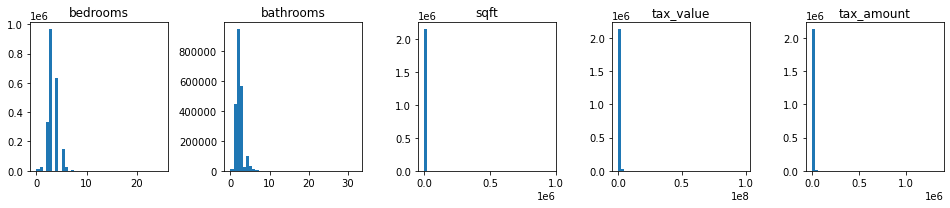

In [13]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, 6, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=40)

    # Hide gridlines.
    plt.grid(False)
    
    #turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    #get rid of overlapping plots
    plt.tight_layout()
    
plt.show()

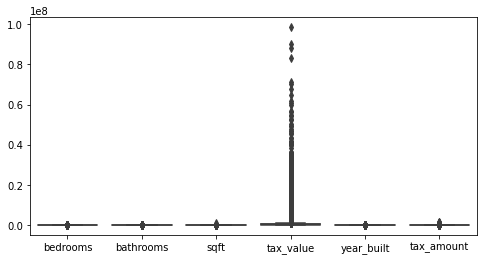

In [14]:
plt.figure(figsize=(8,4))

# Create boxplots for all but fips.
sns.boxplot(data=df.drop(columns=['fips']))
plt.show()

Can we make charts bigger to see if the visualiztion of distribution improves?

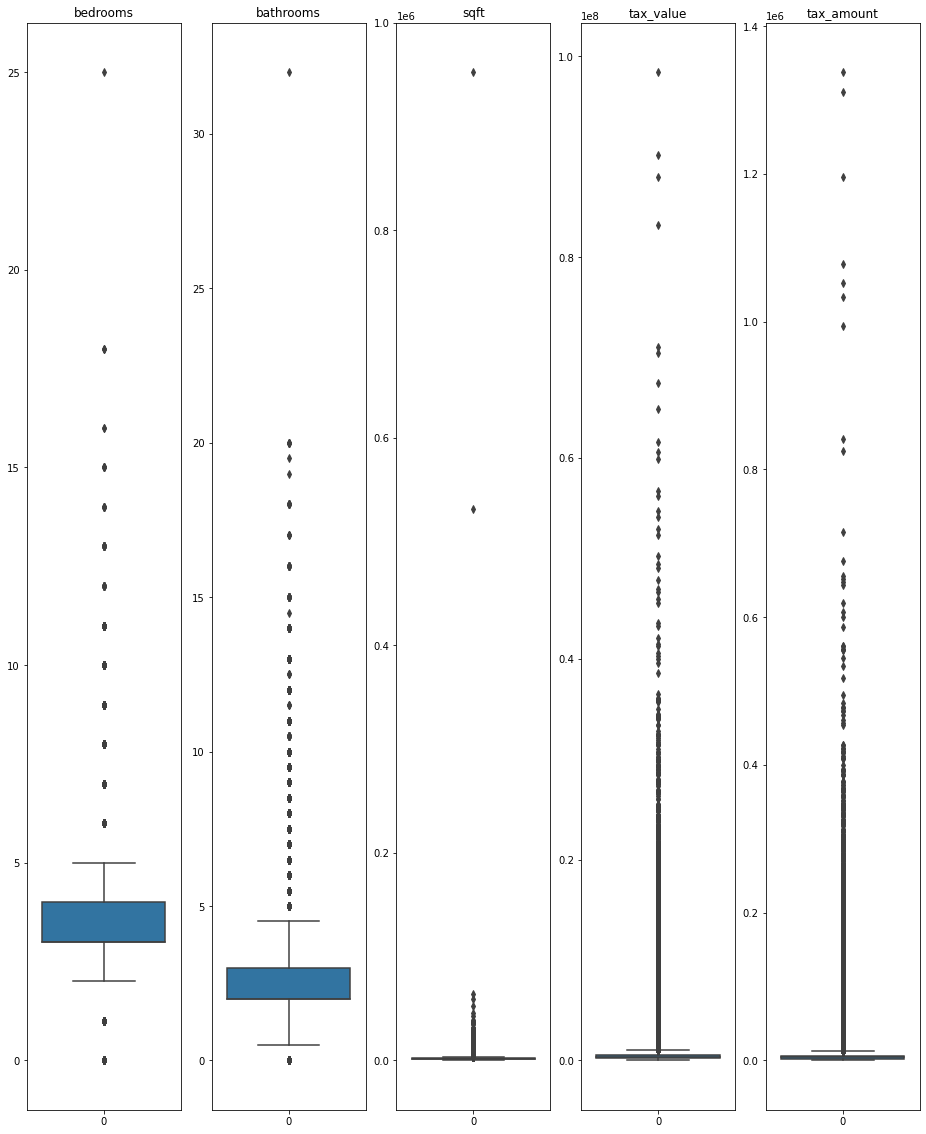

In [15]:
# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]
plt.figure(figsize=(16, 20))
for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[col])

    # Hide gridlines.
    plt.grid(False)

plt.show()

Takeways: 
- Each varibale has outliers skewing the data
- If we will eventually be using data to build a model focusing on median home values, these outliers can be dropped. 

In [16]:
# Create function to remove outliers

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:

        q1, q3 = df[col].quantile([.25, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound

        # return dataframe without outliers
        
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    return df

In [17]:
# Remove outliers from our data
df = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount'])
df.head()

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0
18,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0
19,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0
20,3.0,2.0,1222.0,290492.0,1951.0,3870.25,6037.0


### Reassess Distributions without outliers

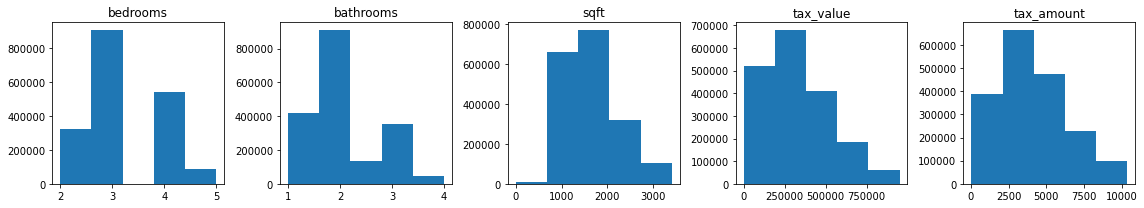

In [18]:
plt.figure(figsize=(16, 3))

# List of columns
cols = [col for col in df.columns if col not in ['fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
    # mitigate overlap
    plt.tight_layout()
    
plt.show()

Takeaways:
- Bedrooms and bathrooms do not have a normal distribution.
- Other fields are close to normal with some remaining skewedness

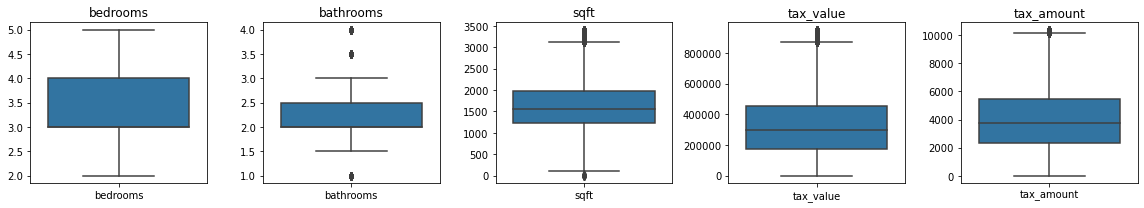

In [19]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'sqft', 'tax_value', 'tax_amount']

plt.figure(figsize=(16, 3))

for i, col in enumerate(cols):

    # i starts at 0, but plot should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display boxplot for column.
    sns.boxplot(data=df[[col]])

    # Hide gridlines.
    plt.grid(False)

    # sets proper spacing between plots
    plt.tight_layout()
    
plt.show()

Takeways:
- Some remaining outliers but no need to remove these

### Reassess and deal with null values

In [20]:
df.isnull().sum()

bedrooms        0
bathrooms       0
sqft            0
tax_value       0
year_built    874
tax_amount      0
fips            0
dtype: int64

In [21]:
df.year_built.describe()

count    1.854411e+06
mean     1.959445e+03
std      2.054604e+01
min      1.801000e+03
25%      1.949000e+03
50%      1.957000e+03
75%      1.972000e+03
max      2.016000e+03
Name: year_built, dtype: float64

Takeways:
- Most null values were removed by removing the outliers
- Mean, median, and mode of our only columns with nulls, year_built, seems tohave mean, median, mode that are close to eachother.
- I will impute year values using the median

### Impute for the null values

In [22]:
imputer = SimpleImputer(strategy='median') #build imputer
imputer.fit(df[['year_built']]) #fit to data

#transform the data
df[['year_built']] = imputer.transform(df[['year_built']])

In [23]:
df.isnull().sum()

bedrooms      0
bathrooms     0
sqft          0
tax_value     0
year_built    0
tax_amount    0
fips          0
dtype: int64

### Change column data types to appropriate types

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855285 entries, 6 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sqft        float64
 3   tax_value   float64
 4   year_built  float64
 5   tax_amount  float64
 6   fips        float64
dtypes: float64(7)
memory usage: 113.2 MB


I will change year_built and fips to onjects since they are categorical values, the rest will remain as floats.

In [25]:
# I will first cast year built and fips as intergers to remove the zeros, then cast as objects
df.year_built = df.year_built.astype(int)
df.fips = df.fips.astype(int)

df.year_built = df.year_built.astype(object)
df.fips = df.fips.astype(object)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1855285 entries, 6 to 2152863
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   bedrooms    float64
 1   bathrooms   float64
 2   sqft        float64
 3   tax_value   float64
 4   year_built  object 
 5   tax_amount  float64
 6   fips        object 
dtypes: float64(5), object(2)
memory usage: 113.2+ MB


### Splitting the data

In [27]:
train_validate, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train_validate, test_size=.3, random_state=123)

In [28]:
train.shape, validate.shape, test.shape

((1038959, 7), (445269, 7), (371057, 7))

### Test my wrangle.py 

Using cached csv...


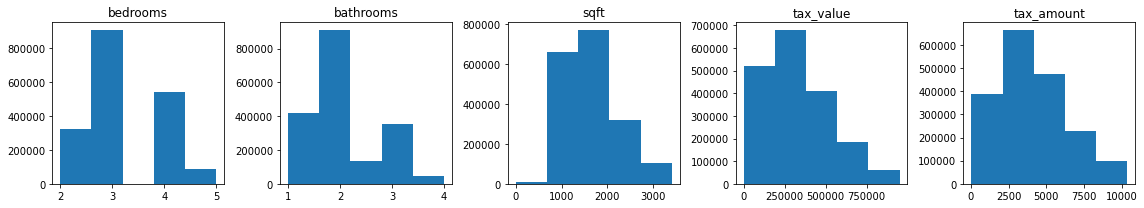

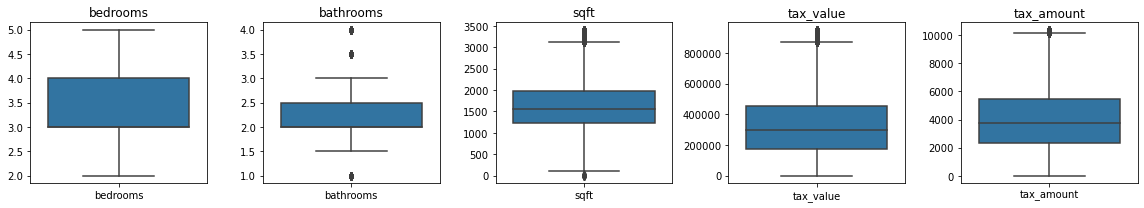

In [29]:
train, validate, test = wr.wrangle_zillow()

In [30]:
train.shape, validate.shape, test.shape

((1038959, 7), (445269, 7), (371057, 7))